**Fittlyf Internship assessment**

In this notebook, the first part and the second part of the internship assessment are solved. The first part deals with the funnel sheet questions and the second part deals with the AB test questions.

**Part 1: Funnel Sheet Questions**

In this part the missing values will be replaced with suitable methods. Then a function will be created that makes the appropriate graphs. Then appropriate models of machine learning like SARIMA, LSTM and MA would be created for forecasting. Lastly they would be evaluated using Accuracy metrics to see which model worked the best.

In [12]:

import pandas as pd

# loading the data
df1 = pd.read_excel("/content/sample_data/Funnel.xlsx")
df1.head()


,Year,Month,Customer Segment,Region,KPI,Value Type,Value
0,2020,12,Clients,India,Lv1_Visitors,Actuals,1354648.0
1,2020,12,Clients,India,Lv2_Visitors,Actuals,2689569.0
2,2020,12,Clients,India,Lv3_Visitors,Actuals,1300571.0
3,2020,12,Clients,India,Lv4_Visitors,Actuals,NaN
4,2020,12,Clients,India,Lv3_Visitors,Actuals,706677.0


In [13]:
# Calculating the mean of the 'Value' column
mean_value = df1['Value'].mean()

# Replacing blank values with the mean
df1['Value'].fillna(mean_value, inplace=True)

In [14]:
#examining the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              1572 non-null   int64  
 1   Month             1572 non-null   int64  
 2   Customer Segment  1572 non-null   object 
 3   Region            1572 non-null   object 
 4   KPI               1572 non-null   object 
 5   Value Type        1572 non-null   object 
 6   Value             1572 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 86.1+ KB


In [15]:
#making collective date column from year and month
df1['date'] = df1['Year'].astype(str) + '-' + df1['Month'].astype(str)
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m')
df1 = df1.sort_values(by='date')
df1.head()

,Year,Month,Customer Segment,Region,KPI,Value Type,Value,date
451,2020,1,Clients,India,Lv1_Visitors,Actuals,3322789.0,2020-01-01
1491,2020,1,Customers,Dehradun,Lv1_Visitors,Actuals,28903.0,2020-01-01
1490,2020,1,Customers,India,Lv5_Visitors,Actuals,42569.0,2020-01-01
1489,2020,1,Customers,Uddepy,Lv4_Visitors,Actuals,48209.0,2020-01-01
1488,2020,1,Customers,Uddepy,Lv2_Visitors,Actuals,75152.0,2020-01-01


In [16]:
#dropping irrelevant columns
df1=df1.drop(['Year','Month'],axis=1)
df1.head()

,Customer Segment,Region,KPI,Value Type,Value,date
451,Clients,India,Lv1_Visitors,Actuals,3322789.0,2020-01-01
1491,Customers,Dehradun,Lv1_Visitors,Actuals,28903.0,2020-01-01
1490,Customers,India,Lv5_Visitors,Actuals,42569.0,2020-01-01
1489,Customers,Uddepy,Lv4_Visitors,Actuals,48209.0,2020-01-01
1488,Customers,Uddepy,Lv2_Visitors,Actuals,75152.0,2020-01-01


In [17]:


import matplotlib.pyplot as plt

#Building a function to generate a graph based on parameters
def generate_graphs(df, region, segment, start_date, end_date):
    # Filter data based on input parameters
    filtered_data = df[(df['Region'] == region) & (df['Customer Segment'] == segment) & (df['date'] >= start_date) & (df['date'] <= end_date)]

    # Making a line graph to show the trend of 'Value' over time
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['date'], filtered_data['Value'], marker='o', linestyle='-', label='Value')

    plt.title(f'Trend of Value for {region} - {segment}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Making  a bar graph to show the counts of different KPIs
    plt.figure(figsize=(10, 6))


    kpi_counts = filtered_data['KPI'].value_counts()

    plt.bar(kpi_counts.index, kpi_counts.values, label='KPI')

    plt.title(f'Trend of KPI for {region} - {segment}')
    plt.xlabel('KPI')
    plt.ylabel('Count')


    if len(kpi_counts) > 5:
        plt.xticks(rotation=45)

    plt.legend()

    plt.show()

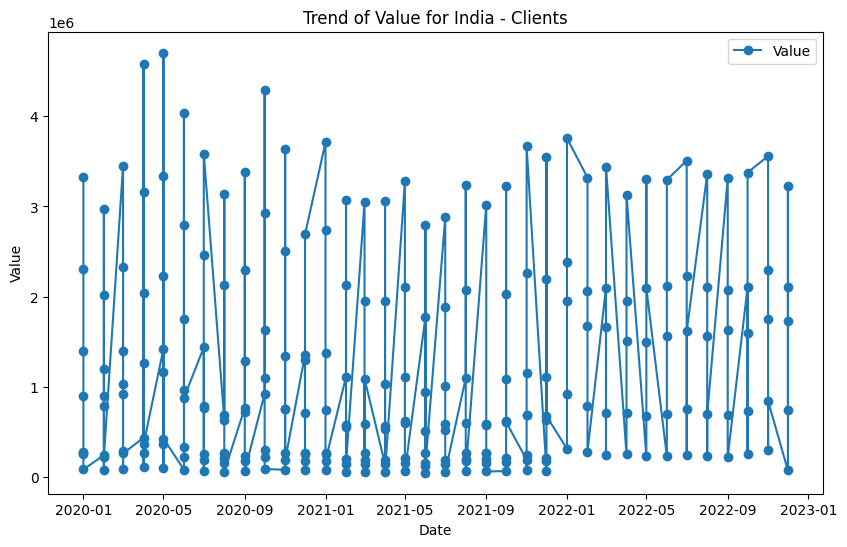

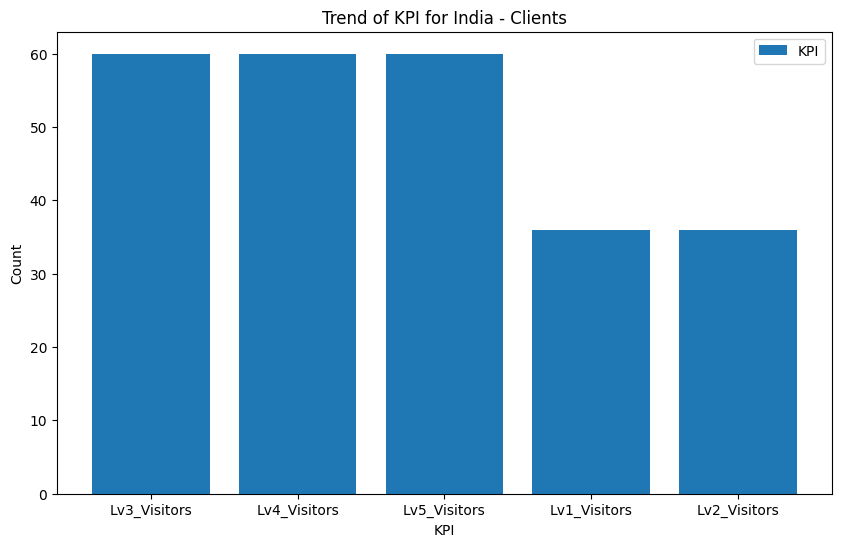

In [18]:
#mock trial
generate_graphs(df1,'India','Clients', '2020-01-01', '2022-12-01')


In [19]:
#getting the necessary packages
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [20]:
#Making the function to train models for SARIMA,MA and LSTM

def train_and_return_models(df, region, segment, start_date, end_date):
    filtered_data = df[(df['Region'] == region) & (df['Customer Segment'] == segment) & (df['date'] >= start_date) & (df['date'] <= end_date)].copy()
    filtered_data = filtered_data[['date', 'Value']].copy()
    filtered_data['date'] = pd.to_numeric(filtered_data['date'])

    sarima_model = train_sarima_model(filtered_data)
    ma_model = train_ma_model(filtered_data)
    lstm_model = train_lstm_model(filtered_data)

    return sarima_model, ma_model, lstm_model


def train_sarima_model(data):
    X_train, X_test = train_test_split(data['Value'], test_size=0.2, shuffle=False)

    order = (1, 0, 0)

    sarima_model = sm.tsa.SARIMAX(X_train,
                                  order=order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

    sarima_results = sarima_model.fit()

    sarima_predictions = sarima_results.get_forecast(steps=len(X_test))

    return pd.DataFrame({'date': X_test.index, 'Value': X_test.values.flatten(), 'predicted_values': sarima_predictions.predicted_mean})


def train_ma_model(data):
     X_train, X_test = train_test_split(data, test_size=0.2, shuffle=False)

     ma_model = LinearRegression()
     ma_model.fit(X_train['date'].values.reshape(-1, 1), X_train['Value'])

     ma_predictions = ma_model.predict(X_test['date'].values.reshape(-1, 1))

     return pd.DataFrame({'date': X_test['date'], 'Value': X_test['Value'], 'predicted_values': ma_predictions})


def train_lstm_model(data):
   X_train, X_test = train_test_split(data.values.flatten(), test_size=0.2, shuffle=False)

   scaler = MinMaxScaler(feature_range=(0, 1))
   scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

   x_train, y_train = [], []
   for i in range(60, len(scaled_data)):
       x_train.append(scaled_data[i-60:i])
       y_train.append(scaled_data[i])

   x_train, y_train = np.array(x_train), np.array(y_train)

   lstm_model = Sequential()
   lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
   lstm_model.add(LSTM(units=50))
   lstm_model.add(Dense(units=1))

   lstm_model.compile(optimizer='adam', loss='mean_squared_error')
   lstm_model.fit(x_train, y_train, epochs=10, batch_size=32)

   inputs = scaled_data[len(scaled_data)-len(X_test)-60:]
   inputs = inputs.reshape(-1,1)
   inputs  = scaler.transform(inputs)

   x_test = []
   for i in range(60, len(inputs)):
        x_test.append(inputs[i-60:i])

   x_test = np.array(x_test)

   lstm_predictions = lstm_model.predict(x_test)
   lstm_predictions = scaler.inverse_transform(lstm_predictions)

   return pd.DataFrame({'date': data.index[-len(X_test):], 'Value': data['Value'].values[-len(X_test):], 'predicted_values': lstm_predictions.flatten()})

In [21]:
#trial run
region = 'India'
segment = 'Customers'
start_date = '2020-01-01'
end_date = '2022-01-01'

sarima_model, ma_model, lstm_model = train_and_return_models(df1, region, segment, start_date, end_date)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Epoch 1/10
6/6 [==============================] - 3s 45ms/step - loss: 0.3327
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.2882
Epoch 3/10
6/6 [==============================] - 0s 44ms/step - loss: 0.2471
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.2568
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.2503
Epoch 6/10
6/6 [==============================] - 0s 41ms/step - loss: 0.2482
Epoch 7/10
6/6 [==============================] - 0s 42ms/step - loss: 0.2453
Epoch 8/10
6/6 [==============================] - 0s 43ms/step - loss: 0.2444
Epoch 9/10
6/6 [==============================] - 0s 43ms/step - loss: 0.2451
Epoch 10/10
2/2 [==============================] - 1s 13ms/step


In [22]:
# Printing the sarima dataset
print("SARIMA Model Dataset:")
print(sarima_model)


SARIMA Model Dataset:
     date          Value  predicted_values
100   794  322087.000000     296815.810100
101   793  339528.000000     230950.137431
102   792  465658.000000     179700.555578
103   795  268584.458953     139823.643468
104   805   20305.000000     108795.719690
105   717   17315.000000      84653.126819
106   706   71396.000000      65867.957863
107   704  264643.000000      51251.359945
108   703  303181.000000      39878.295630
109   702  442574.000000      31029.000285
110   622   19882.000000      24143.430492
111   612  420940.000000      18785.820703
112   613  292771.000000      14617.105038
113   614  233125.000000      11373.458901
114   615   79269.000000       8849.602369
115   535   18591.000000       6885.808686
116   522  469431.000000       5357.795671
117   524  232479.000000       4168.860298
118   525   88949.000000       3243.758674
119   523  330165.000000       2523.944096
120  1552   19861.000000       1963.861816
121  1542  447793.000000       1

In [23]:
# Printing the MA dataset
print("\nMA Model Dataset:")
print(ma_model)



MA Model Dataset:
                     date          Value  predicted_values
794   1630454400000000000  322087.000000     371831.215804
793   1630454400000000000  339528.000000     371831.215804
792   1630454400000000000  465658.000000     371831.215804
795   1630454400000000000  268584.458953     371831.215804
805   1630454400000000000   20305.000000     371831.215804
717   1633046400000000000   17315.000000     371253.598807
706   1633046400000000000   71396.000000     371253.598807
704   1633046400000000000  264643.000000     371253.598807
703   1633046400000000000  303181.000000     371253.598807
702   1633046400000000000  442574.000000     371253.598807
622   1635724800000000000   19882.000000     370656.727910
612   1635724800000000000  420940.000000     370656.727910
613   1635724800000000000  292771.000000     370656.727910
614   1635724800000000000  233125.000000     370656.727910
615   1635724800000000000   79269.000000     370656.727910
535   1638316800000000000   18591.000

In [24]:
# Printing the LSTM dataset
print("\nLSTM Model Dataset:")
print(lstm_model)


LSTM Model Dataset:
    date          Value  predicted_values
0   1242  642725.000000      2.202322e+17
1   1244  520986.000000      2.202322e+17
2   1245  220736.000000      2.202322e+17
3   1249   57046.000000      2.202322e+17
4   1243  530740.000000      2.202322e+17
5   1159   45563.000000      2.202322e+17
6   1152  608351.000000      2.202322e+17
7   1153  513130.000000      2.202322e+17
8   1154  492346.000000      2.202322e+17
9   1155  200638.000000      2.202322e+17
10  1063  469601.000000      2.202322e+17
11  1064  449360.000000      2.202322e+17
12  1065  187122.000000      2.202322e+17
13  1069   40750.000000      2.202322e+17
14  1062  563598.000000      2.202322e+17
15   979   37264.000000      2.202322e+17
16   972  535634.000000      2.202322e+17
17   973  431464.000000      2.202322e+17
18   974  427893.000000      2.202322e+17
19   975  176228.000000      2.202322e+17
20   882  502679.000000      2.202322e+17
21   889   24110.000000      2.202322e+17
22   885  132

In [25]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

#calculating the error metrics
def calculate_error_metrics(dataset):
    actual_values = dataset['Value'].values
    predicted_values = dataset['predicted_values'].values

    mape = mean_absolute_percentage_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)

    return mape, mse


In [26]:
# Getting the error metrics for SARIMA


mape, mse = calculate_error_metrics(sarima_model)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Percentage Error (MAPE): 1.0326339956706214
Mean Squared Error (MSE): 57324776334.51824


In [27]:
# Getting the error metrics for MA


mape, mse = calculate_error_metrics(ma_model)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Percentage Error (MAPE): 4.438168995752023
Mean Squared Error (MSE): 43404644856.10021


In [28]:
# Getting the error metrics for LSTM


mape, mse = calculate_error_metrics(lstm_model)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Percentage Error (MAPE): 2438313490542.1436
Mean Squared Error (MSE): 4.850223569018413e+34


**Remark**

Due to the lowest error rate in SARIMA the Sarima Model has been chosen.

In [29]:
# Converting the datasets to csv
file_path_df1 = 'sarima_model.csv'
file_path_df2 = 'ma_model.csv'
file_path_df3 = 'lstm_model.csv'


sarima_model.to_csv(file_path_df1, index=False)
ma_model.to_csv(file_path_df2, index=False)
lstm_model.to_csv(file_path_df3, index=False)




In [30]:
#subsetting the dataset

subset_df = df1[df1['KPI'] == 'Lv5_Visitors']
subset_df

,Customer Segment,Region,KPI,Value Type,Value,date
1490,Customers,India,Lv5_Visitors,Actuals,42569.0,2020-01-01
456,Clients,India,Lv5_Visitors,Actuals,278010.0,2020-01-01
458,Clients,India,Lv5_Visitors,Actuals,85929.0,2020-01-01
1507,Customers,Dehradun,Lv5_Visitors,Actuals,3875.0,2020-01-01
1511,Customers,Aurangabad,Lv5_Visitors,Actuals,934.0,2020-01-01
...,...,...,...,...,...,...
580,Customers,Ujjain,Lv5_Visitors,Actuals,293.0,2022-12-01
571,Customers,India,Lv5_Visitors,Actuals,4625.0,2022-12-01
576,Customers,Uddepy,Lv5_Visitors,Actuals,1492.0,2022-12-01
578,Customers,Faridabad,Lv5_Visitors,Actuals,399.0,2022-12-01


In [31]:
#seeing the combination with the highest customer count

combination_counts = subset_df.groupby(['Region', 'Customer Segment', 'Value Type', 'date']).size().reset_index(name='Value Count')


sorted_combinations = combination_counts.sort_values(by='Value Count', ascending=False)


top_5_combinations = sorted_combinations.head(5)
top_5_combinations

,Region,Customer Segment,Value Type,date,Value Count
122,India,Clients,Actuals,2020-03-01,2
130,India,Clients,Actuals,2020-11-01,2
139,India,Clients,Actuals,2021-08-01,2
138,India,Clients,Actuals,2021-07-01,2
137,India,Clients,Actuals,2021-06-01,2


In [32]:
# Finding the combination for highest CAC

customer_count = subset_df.groupby(['Region','Customer Segment','Value Type', 'date']).size()
CAC = (customer_count * 100) / 100000
top_10_CAC_regions = CAC.sort_values(ascending=False).head(10)
top_10_CAC_regions


Region  Customer Segment  Value Type  date      
India   Clients           Actuals     2020-03-01    0.002
                                      2020-11-01    0.002
                                      2021-08-01    0.002
                                      2021-07-01    0.002
                                      2021-06-01    0.002
                                      2021-04-01    0.002
                                      2021-03-01    0.002
                                      2021-02-01    0.002
                                      2021-01-01    0.002
                                      2020-12-01    0.002
dtype: float64

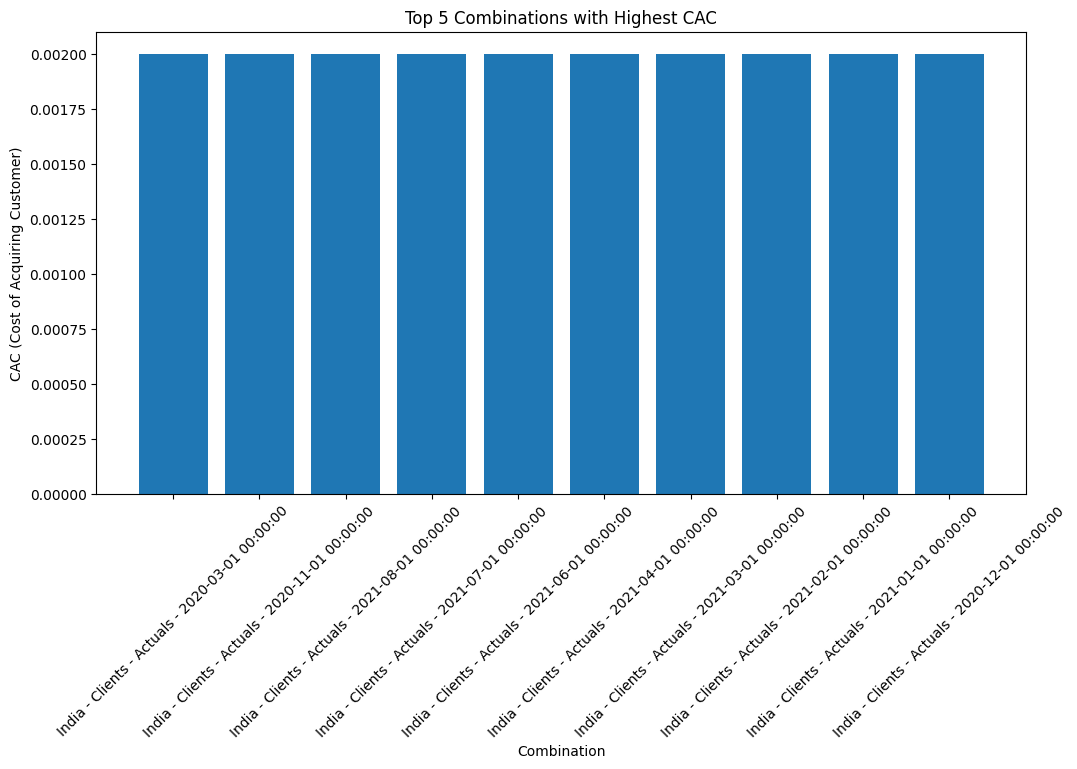

In [33]:
# Creating a bar plot to visualize CAC for the top 10 top_10_CAC_regions
top_10_CAC_regions.index = [f'{index[0]} - {index[1]} - {index[2]} - {index[3]}' for index in top_10_CAC_regions.index]


plt.figure(figsize=(12, 6))
plt.bar(top_10_CAC_regions.index, top_10_CAC_regions.values)
plt.xlabel('Combination')
plt.ylabel('CAC (Cost of Acquiring Customer)')
plt.title('Top 5 Combinations with Highest CAC')
plt.xticks(rotation=45)

plt.show()

In [34]:
#seeing which combination generates the highest revenue
value_sum = subset_df.groupby(['Region','Customer Segment','Value Type', 'date'])['Value'].sum()
top_5_values = value_sum.sort_values(ascending=False).head(5)

top_5_values

Region  Customer Segment  Value Type  date      
India   Clients           Actuals     2020-04-01    555127.0
                                      2020-05-01    535507.0
                                      2020-06-01    415727.0
                                      2020-10-01    394290.0
                                      2020-03-01    380754.0
Name: Value, dtype: float64

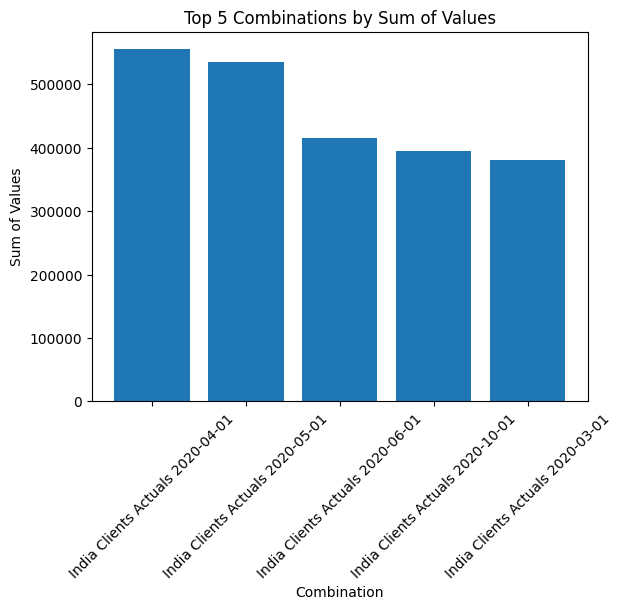

In [35]:
# Visualizing  which combination generates the highest revenue
top_5_values.index = [f"{region} {kpi} {value_type} {date.strftime('%Y-%m-%d')}" for region, kpi, value_type, date in top_5_values.index]

plt.bar(top_5_values.index.astype(str), top_5_values.values)
plt.xlabel('Combination')
plt.ylabel('Sum of Values')
plt.title('Top 5 Combinations by Sum of Values')
plt.xticks(rotation=45)
plt.show()

In [36]:
#subsetting for location Dehradun
dh_df = df1[df1['Region'] == 'Dehradun']
dh_df

,Customer Segment,Region,KPI,Value Type,Value,date
1491,Customers,Dehradun,Lv1_Visitors,Actuals,28903.0,2020-01-01
1495,Customers,Dehradun,Lv2_Visitors,Actuals,21332.0,2020-01-01
1507,Customers,Dehradun,Lv5_Visitors,Actuals,3875.0,2020-01-01
1494,Customers,Dehradun,Lv3_Visitors,Actuals,25380.0,2020-01-01
1502,Customers,Dehradun,Lv4_Visitors,Actuals,8578.0,2020-01-01
...,...,...,...,...,...,...
28,Clients,Dehradun,Lv3_Visitors,Actuals,118570.0,2022-12-01
567,Customers,Dehradun,Lv3_Visitors,Actuals,8196.0,2022-12-01
574,Customers,Dehradun,Lv4_Visitors,Actuals,2561.0,2022-12-01
579,Customers,Dehradun,Lv5_Visitors,Actuals,357.0,2022-12-01


In [37]:
#checking the Lv5 to Lv1 ratio of this region
ratio=len(dh_df[dh_df['KPI'] == 'Lv5_Visitors'])/len(dh_df[dh_df['KPI'] == 'Lv1_Visitors'])
ratio

1.0

In [38]:
#checking the CAC ratio of this region
CAC = len(dh_df[dh_df['KPI'] == 'Lv5_Visitors'])* 100 / 100000
CAC

0.048

In [39]:

# Using the sarima model to predict the values for Dehradun region for upcoming Quarter
order = (1, 0, 0)
sarima_model = sm.tsa.SARIMAX(dh_df['Value'], order=order, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()


start_date = '2023-01-01'
end_date = '2023-04-01'


forecast = sarima_results.get_forecast(steps=len(pd.date_range(start_date, end_date, freq='D')))

predicted_values = forecast.predicted_mean
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')


predicted_df_dh = pd.DataFrame({'Date': forecast_dates, 'Predicted_Value': predicted_values})

print(predicted_df_dh)

          Date  Predicted_Value
240 2023-01-01     8.413609e+03
241 2023-01-02     4.212116e+03
242 2023-01-03     2.108717e+03
243 2023-01-04     1.055690e+03
244 2023-01-05     5.285113e+02
..         ...              ...
326 2023-03-28     1.212073e-22
327 2023-03-29     6.068017e-23
328 2023-03-30     3.037839e-23
329 2023-03-31     1.520837e-23
330 2023-04-01     7.613787e-24

[91 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


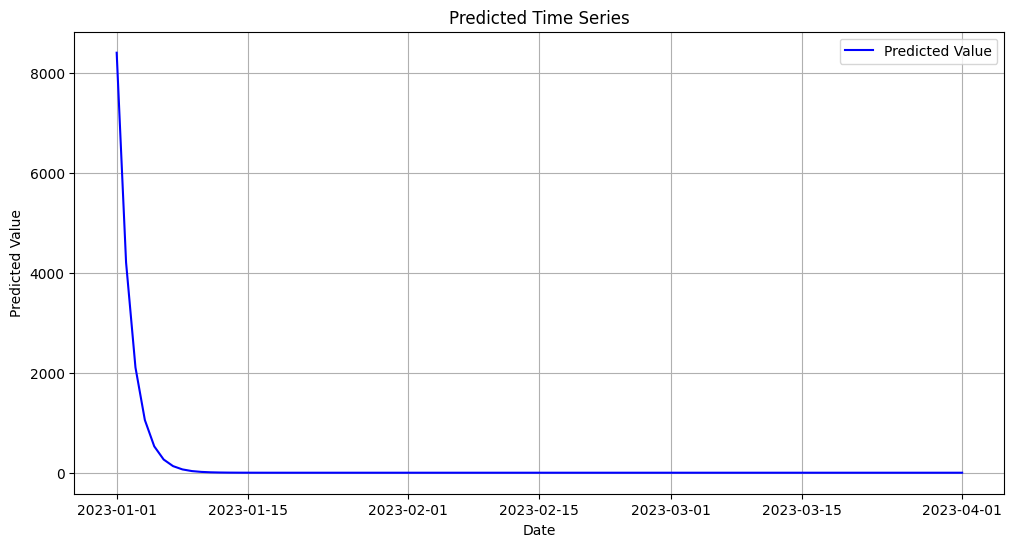

In [40]:
# Creating a time series plot for the same
predicted_df_dh.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(predicted_df_dh.index, predicted_df_dh['Predicted_Value'], label='Predicted Value', color='blue')
plt.title('Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
#subsetting for location Uddepy
dh_Ud = df1[df1['Region'] == 'Uddepy']
dh_Ud

,Customer Segment,Region,KPI,Value Type,Value,date
1489,Customers,Uddepy,Lv4_Visitors,Actuals,48209.0,2020-01-01
1488,Customers,Uddepy,Lv2_Visitors,Actuals,75152.0,2020-01-01
1487,Customers,Uddepy,Lv1_Visitors,Actuals,103882.0,2020-01-01
1486,Customers,Uddepy,Lv3_Visitors,Actuals,108349.0,2020-01-01
1498,Customers,Uddepy,Lv5_Visitors,Actuals,15447.0,2020-01-01
...,...,...,...,...,...,...
27,Clients,Uddepy,Lv4_Visitors,Actuals,118950.0,2022-12-01
22,Clients,Uddepy,Lv3_Visitors,Actuals,371666.0,2022-12-01
37,Clients,Uddepy,Lv5_Visitors,Actuals,14855.0,2022-12-01
565,Customers,Uddepy,Lv4_Visitors,Actuals,16241.0,2022-12-01


In [42]:
#checking the Lv5 to Lv1 ratio of this region
ratio=len(dh_Ud[dh_Ud['KPI'] == 'Lv5_Visitors'])/len(dh_Ud[dh_Ud['KPI'] == 'Lv1_Visitors'])
ratio

1.0

In [43]:
#checking the CAC ratio of this region
CAC = len(dh_Ud[dh_Ud['KPI'] == 'Lv5_Visitors'])* 100 / 100000
CAC

0.048

In [44]:
# Using the sarima model to predict the values for Uddepy region for upcoming Quarter
order = (1, 0, 0)
sarima_model = sm.tsa.SARIMAX(dh_Ud['Value'], order=order, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()


start_date = '2023-01-01'
end_date = '2023-04-01'


forecast = sarima_results.get_forecast(steps=len(pd.date_range(start_date, end_date, freq='D')))

predicted_values = forecast.predicted_mean
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')


predicted_df_ud= pd.DataFrame({'Date': forecast_dates, 'Predicted_Value': predicted_values})

print(predicted_df_ud)

          Date  Predicted_Value
240 2023-01-01     9.037655e+02
241 2023-01-02     5.474477e+02
242 2023-01-03     3.316115e+02
243 2023-01-04     2.008707e+02
244 2023-01-05     1.216756e+02
..         ...              ...
326 2023-03-28     1.708958e-16
327 2023-03-29     1.035186e-16
328 2023-03-30     6.270543e-17
329 2023-03-31     3.798325e-17
330 2023-04-01     2.300801e-17

[91 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


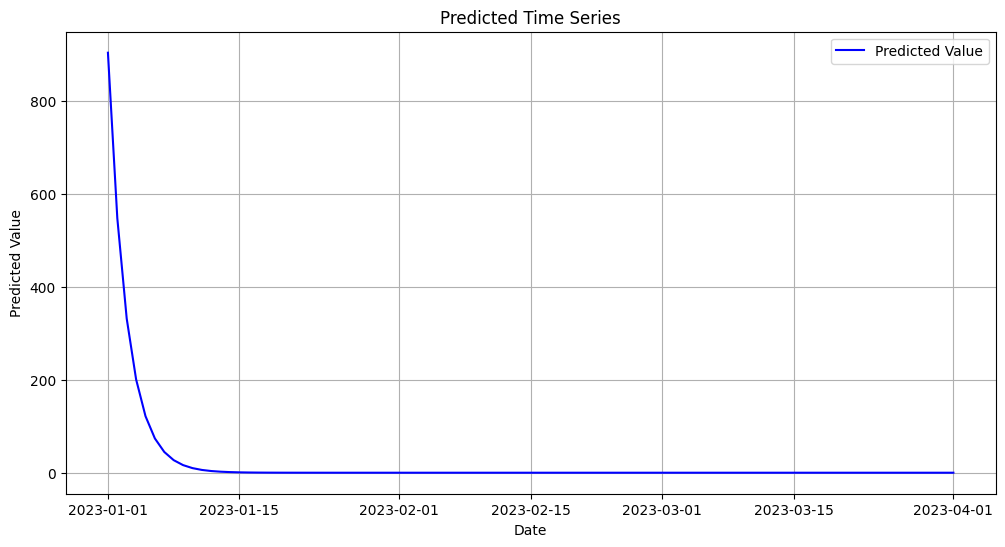

In [45]:
# Creating a time series plot for the same
predicted_df_ud.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(predicted_df_ud.index, predicted_df_ud['Predicted_Value'], label='Predicted Value', color='blue')
plt.title('Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#subsetting for location Indore
dh_in = df1[df1['Region'] == 'Indore']
dh_in

,Customer Segment,Region,KPI,Value Type,Value,date
490,Clients,Indore,Lv5_Visitors,Actuals,19556.0,2022-01-01
487,Clients,Indore,Lv4_Visitors,Actuals,40124.0,2022-01-01
479,Clients,Indore,Lv1_Visitors,Actuals,147244.0,2022-01-01
482,Clients,Indore,Lv2_Visitors,Actuals,85963.0,2022-01-01
484,Clients,Indore,Lv3_Visitors,Actuals,74326.0,2022-01-01
442,Clients,Indore,Lv2_Visitors,Actuals,73121.0,2022-02-01
444,Clients,Indore,Lv3_Visitors,Actuals,62801.0,2022-02-01
447,Clients,Indore,Lv4_Visitors,Actuals,33654.0,2022-02-01
450,Clients,Indore,Lv5_Visitors,Actuals,16621.0,2022-02-01
438,Clients,Indore,Lv1_Visitors,Actuals,127288.0,2022-02-01


In [47]:
#checking the Lv5 to Lv1 ratio of this region
ratio=len(dh_in[dh_in['KPI'] == 'Lv5_Visitors'])/len(dh_in[dh_in['KPI'] == 'Lv1_Visitors'])
ratio

1.0

In [48]:
#checking the CAC ratio of this region
CAC = len(dh_in[dh_in['KPI'] == 'Lv5_Visitors'])* 100 / 100000
CAC

0.012

In [49]:
# Using the sarima model to predict the values for indore region for upcoming Quarter
order = (1, 0, 0)
sarima_model = sm.tsa.SARIMAX(dh_in['Value'], order=order, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()


start_date = '2023-01-01'
end_date = '2023-04-01'


forecast = sarima_results.get_forecast(steps=len(pd.date_range(start_date, end_date, freq='D')))

predicted_values = forecast.predicted_mean
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')


predicted_df_in= pd.DataFrame({'Date': forecast_dates, 'Predicted_Value': predicted_values})

print(predicted_df_in)

          Date  Predicted_Value
60  2023-01-01     8.781801e+04
61  2023-01-02     6.454910e+04
62  2023-01-03     4.744569e+04
63  2023-01-04     3.487412e+04
64  2023-01-05     2.563362e+04
..         ...              ...
146 2023-03-28     2.792212e-07
147 2023-03-29     2.052367e-07
148 2023-03-30     1.508556e-07
149 2023-03-31     1.108838e-07
150 2023-04-01     8.150319e-08

[91 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


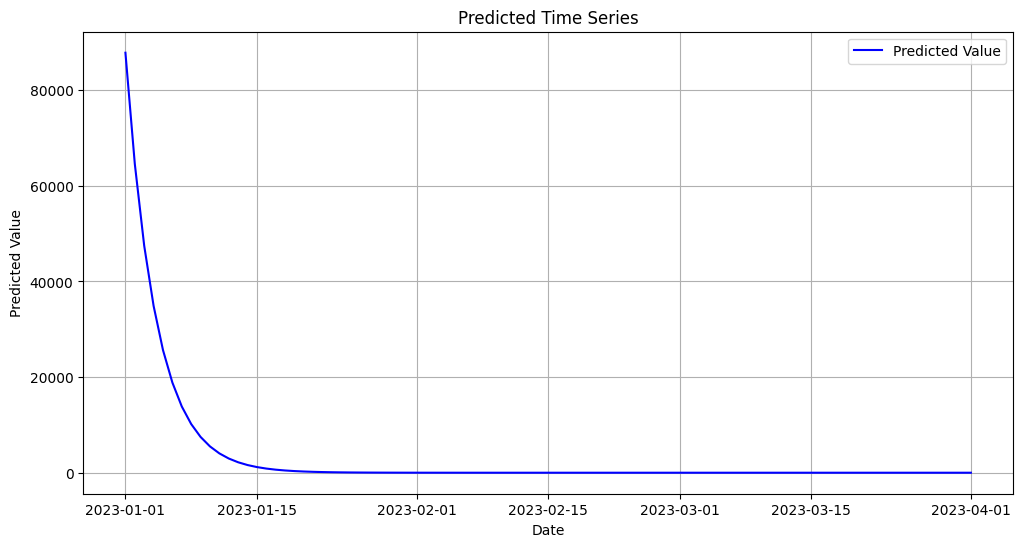

In [50]:
# Creating a time series plot for the same
predicted_df_in.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(predicted_df_in.index, predicted_df_in['Predicted_Value'], label='Predicted Value', color='blue')
plt.title('Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
#subsetting for location Ujjain
dh_uj = df1[df1['Region'] == 'Ujjain']
dh_uj

,Customer Segment,Region,KPI,Value Type,Value,date
1492,Customers,Ujjain,Lv3_Visitors,Actuals,25661.0,2020-01-01
1493,Customers,Ujjain,Lv1_Visitors,Actuals,25434.0,2020-01-01
1508,Customers,Ujjain,Lv5_Visitors,Actuals,3393.0,2020-01-01
1501,Customers,Ujjain,Lv4_Visitors,Actuals,9881.0,2020-01-01
1496,Customers,Ujjain,Lv2_Visitors,Actuals,19891.0,2020-01-01
...,...,...,...,...,...,...
580,Customers,Ujjain,Lv5_Visitors,Actuals,293.0,2022-12-01
563,Customers,Ujjain,Lv1_Visitors,Actuals,18327.0,2022-12-01
566,Customers,Ujjain,Lv2_Visitors,Actuals,11600.0,2022-12-01
568,Customers,Ujjain,Lv3_Visitors,Actuals,6821.0,2022-12-01


In [52]:
#checking the Lv5 to Lv1 ratio of this region
ratio=len(dh_uj[dh_uj['KPI'] == 'Lv5_Visitors'])/len(dh_uj[dh_uj['KPI'] == 'Lv1_Visitors'])
ratio

1.0

In [53]:
#checking the CAC ratio of this region
CAC = len(dh_uj[dh_uj['KPI'] == 'Lv5_Visitors'])* 100 / 100000
CAC

0.048

In [54]:
# Using the sarima model to predict the values for Ujjain region for upcoming Quarter
order = (1, 0, 0)
sarima_model = sm.tsa.SARIMAX(dh_in['Value'], order=order, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()


start_date = '2023-01-01'
end_date = '2023-04-01'


forecast = sarima_results.get_forecast(steps=len(pd.date_range(start_date, end_date, freq='D')))

predicted_values = forecast.predicted_mean
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')


predicted_df_uj= pd.DataFrame({'Date': forecast_dates, 'Predicted_Value': predicted_values})

print(predicted_df_uj)

          Date  Predicted_Value
60  2023-01-01     8.781801e+04
61  2023-01-02     6.454910e+04
62  2023-01-03     4.744569e+04
63  2023-01-04     3.487412e+04
64  2023-01-05     2.563362e+04
..         ...              ...
146 2023-03-28     2.792212e-07
147 2023-03-29     2.052367e-07
148 2023-03-30     1.508556e-07
149 2023-03-31     1.108838e-07
150 2023-04-01     8.150319e-08

[91 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


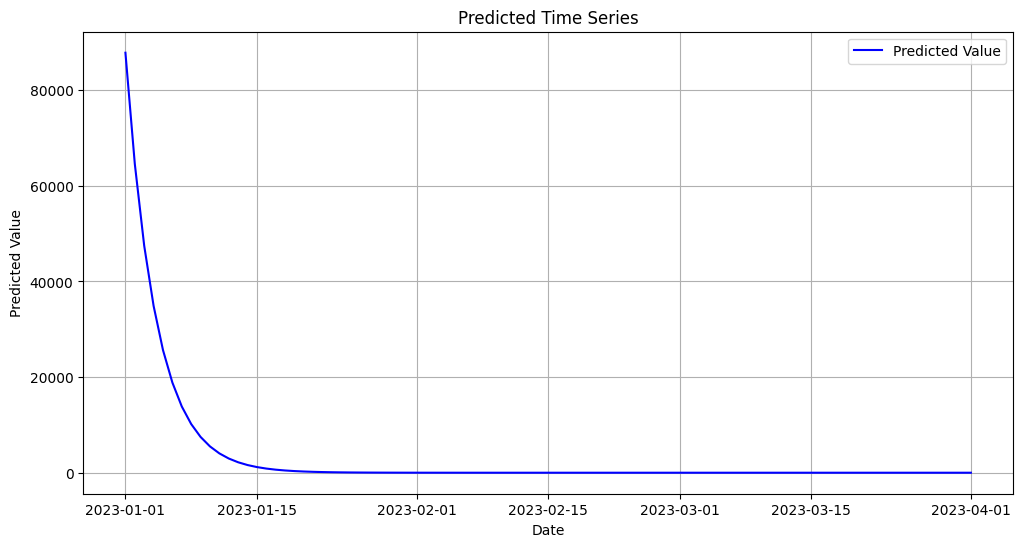

In [55]:
# Creating a time series plot for the same
predicted_df_uj.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(predicted_df_uj.index, predicted_df_uj['Predicted_Value'], label='Predicted Value', color='blue')
plt.title('Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()

**Part 2:AB Test Questions**

In this segment we are going to be creating functions that automate the hypothesis Testing.

In [69]:
#getting the dataset
df2=pd.read_excel('/content/sample_data/ABtest.xlsx')
df2.head()

,Months (Date),Date,Variants,DeviceType,Sum of Clicks,Sum of Visitors
0,Mar,2023-03-29,Control,Desktop,31312,298032
1,Mar,2023-03-29,Control,Mobile,18399,192144
2,Mar,2023-03-29,Control,Others,34,375
3,Mar,2023-03-29,Control,Tablet,660,7646
4,Mar,2023-03-29,Treatment,Desktop,10067,32737


In [70]:
#dropping timestamp
df2=df2.drop(['Date'],axis=1)
df2.head()

,Months (Date),Variants,DeviceType,Sum of Clicks,Sum of Visitors
0,Mar,Control,Desktop,31312,298032
1,Mar,Control,Mobile,18399,192144
2,Mar,Control,Others,34,375
3,Mar,Control,Tablet,660,7646
4,Mar,Treatment,Desktop,10067,32737


In [71]:
#making a new feature
df2['CTR'] = (df2['Sum of Clicks'] / df2['Sum of Visitors']) * 100
df2['CTR']

0      10.506254
1       9.575631
2       9.066667
3       8.631964
4      30.751138
         ...    
139    10.183790
140    24.704114
141    15.351082
142     8.108108
143    17.945007
Name: CTR, Length: 144, dtype: float64

In [75]:
#subsetting according to needs
Control_data=df2[df2['Variants'] == 'Control']
Treatment_data=df2[df2['Variants'] == 'Treatment']
Desktop_data=df2[df2['Variants'] == 'Desktop']
Mobile_data=df2[df2['Variants'] == 'Mobile']

In [86]:
import statsmodels.stats.api as sms

# Checking if we have reached the minimum sample size
MDE = 0.03  # Minimum Detectable Effect (3%)
alpha = 0.05  # Significance level (95%)
power = 0.80  # Statistical power (80%)


effect_size = sms.proportion_effectsize(0.5, 0.5 + MDE)
required_sample_size = sms.NormalIndPower().solve_power(effect_size, power, alpha, ratio=1)


actual_sample_size = len(df2)
if actual_sample_size >= required_sample_size:
    print("The required sample size has been reached.")
else:
    print("More data is needed to reach the required sample size.")

The required sample size has been reached.


In [87]:
from scipy import stats

# Checking  for statistical significance at 95% confidence
control_group = Control_data['CTR']
treatment_group = Treatment_data['CTR']
alpha = 0.05

t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

if p_value < alpha:
    print("The test has reached statistical significance at 95% confidence.")
else:
    print("The test has not reached statistical significance at 95% confidence.")

The test has reached statistical significance at 95% confidence.


In [88]:
from scipy import stats
# Defining significance level (alpha)
alpha = 0.05

# Function to check for statistical significance
def check_statistical_significance(group1, group2, alpha):
    t_stat, p_value = stats.ttest_ind(group1, group2)
    return p_value < alpha

In [89]:
# Performing the test for overall data vs. desktop data
overall_group = df2['CTR']
desktop_group = Desktop_data['CTR']
overall_vs_desktop_significance = check_statistical_significance(overall_group, desktop_group, alpha)

# Checking if each comparison reaches statistical significance
if overall_vs_desktop_significance:
    print("The test for overall data vs. desktop data has reached statistical significance.")
else:
    print("The test for overall data vs. desktop data has not reached statistical significance.")

The test for overall data vs. desktop data has not reached statistical significance.


In [91]:
# Perform the test for overall data vs. mobile data
mobile_group = Mobile_data['CTR']
overall_vs_mobile_significance = check_statistical_significance(overall_group, mobile_group, alpha)

# Checking if each comparison reaches statistical significance
if overall_vs_mobile_significance:
    print("The test for overall data vs. mobile data has reached statistical significance.")
else:
    print("The test for overall data vs. mobile data has not reached statistical significance.")

The test for overall data vs. mobile data has not reached statistical significance.


**Conclusion**

We can conclude the following:


1.The required sample size for the test has been reached. which means we collected enough data to perform a reliable statistical analysis.

2.The test has reached statistical significance at a 95% confidence level. This indicates the change in the sign-up button color has had a measurable impact on the Click-Through Rate (CTR) for the entire audience.

3.Desktop and Mobile Significance: The test for the desktop and mobile segment data has not reached statistical significance which means that there is no statistically significant difference in CTR between the control and treatment groups for users on these devices.
